In [1]:
import os
from importlib.resources import files

import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry
from learn_embedding.utils import Trainer, LasaHandwriting, TorchHelper, Integrator, Obstacles

## Load Dataset

In [2]:
dataset = "Angle"
data_path = files('learn_embedding').joinpath(os.path.join('data', '{}.mat'.format("Angle")))
data = LasaHandwriting(data_path)
train_x, train_y, test_x, test_y = data.load().process().dataset(target="velocity", split=0.6, visualize=False)
dim = train_y.shape[1]

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device).requires_grad_(True)
test_y = torch.from_numpy(test_y).float().to(device)

## Create Model

In [4]:
# approximator = KernelExpansion(train_x)
# approximator = KernelMachine(dim, 1000, 1, length=0.4)
approximator = FeedForward(dim, [64], 1)

embedding = Embedding(approximator)

stiffness = SPD(dim)

attractor = train_x[-1, :]

model = FirstGeometry(embedding, attractor, stiffness).to(device)
# model = TorchHelpel.load(model,)

## Train

In [5]:
trainer = Trainer(model, train_x, train_y)
trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
# trainer.loss = torch.nn.MSELoss()
trainer.loss = torch.nn.SmoothL1Loss()
trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=10000)
# trainer.train()
# TorchHelpel.save(model,)

## Test

In [6]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
y, x = torch.meshgrid(torch.linspace(min_ax[1], max_ax[1], resolution), torch.linspace(min_ax[0], max_ax[0], resolution))
grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_r = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)

/home/bernardo/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Potential

(-10.061845779418945, 48.22831344604492)

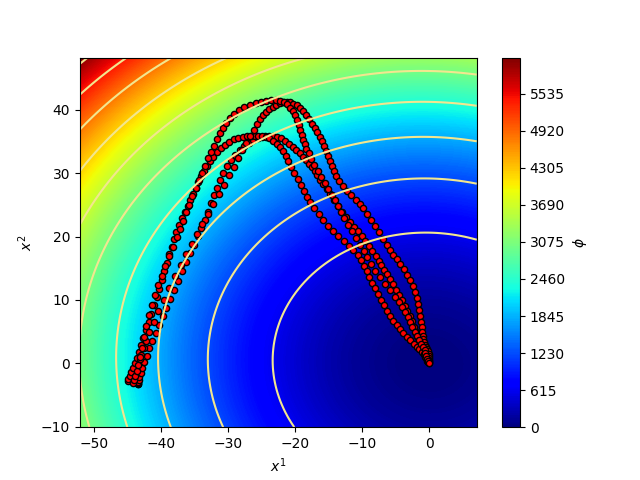

In [8]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()
norm = matplotlib.colors.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::10, 0], train_x.cpu().detach()[::10, 1], s=20, edgecolors='k', c='red')
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
fig.colorbar(im, ax=ax, label=r"$\phi$")
# ax.axis("equal")
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

### Vector Field & Streamlines

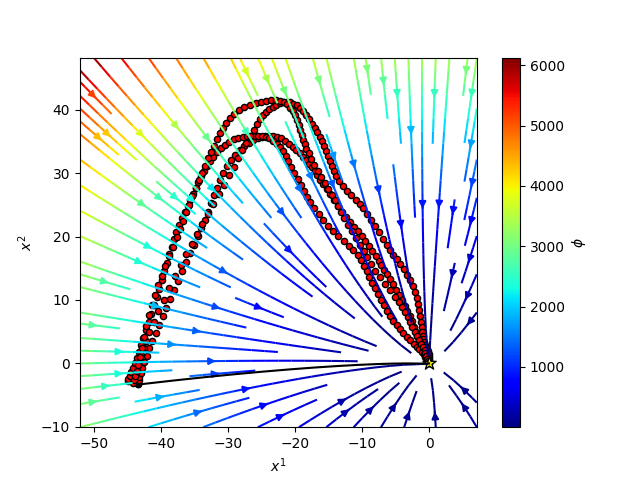

In [9]:
field = model(grid_x)
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), length=0.03, samples=1).to(device).requires_grad_(True)
streamlines = Integrator.first_order(dynamics=model,x0=x0,T=20, dt=0.01).cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet")
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k')
ax.scatter(train_x.cpu().detach()[::10, 0], train_x.cpu().detach()[::10, 1], s=20, edgecolors='k', c='red')
ax.scatter(train_x.cpu().detach()[-1, 0], train_x.cpu().detach()[-1, 1], s=100, edgecolors='k', c='yellow', marker="*")
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
fig.colorbar(mappable,  ax=ax, label=r"$\phi$")

### Embedding

In [ ]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x).cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
im = ax.plot_surface(x_embedding, y_embedding, z_embedding,facecolors=colors, antialiased=True, linewidth=0, alpha=0.5)
ax.scatter(train_embedding[::10, 0], train_embedding[::10, 1], train_embedding[::10, 2], s=20, edgecolors='k', c='red')
ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')
fig.colorbar(mappable, ax=ax, label=r"$\phi$")

### Metric

In [ ]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_r)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_r, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)
ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

norm = matplotlib.colors.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x, y, det_metric, 500, cmap="jet")
ax.scatter(x[10::10,10::10,], y[10::10,10::10], color="k", s=1)

for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i,:], ellipses_y[i,:], color="k", linewidth=0.5)

fig.colorbar(mappable,  ax=ax, label=r"$det(g)$")